In [1]:
import pandas as pd
import numpy as np
from seeq import spy

# Set the compatibility option so that you maximize the chance that SPy will remain compatible with your notebook/script
spy.options.compatibility = 193

In [2]:
# Log into Seeq Server if you're not using Seeq Data Lab:
spy.login(url='http://localhost:34216', credentials_file='../credentials.key', force=False)

# Asset Trees 3: Report and Dashboard Templates

This tutorial leverages the capabilities of the **spy.assets** templates (as described in [Asset Trees 2 - Templates](Asset%20Trees%202%20-%20Templates.ipynb)) and **spy.workbooks** templates (as described in [Workbook Templates](Workbook%20Templates.ipynb)) to show you how to create Displays, Analysis Workbooks/Worksheets and Organizer Topics for your asset tree.

First, some definitions:

- **Display**: The definition of a visualization that can be rendered in Seeq Workbench. A Display can be a Trend, XY Plot, Treemap or Table. Technically speaking, a Display corresponds to what Seeq refers to internally as a **Workstep**.
- **Document**: In Seeq Organizer, each "worksheet" on the left-hand side of the display is called a Topic _Document_. Documents have rich text, images, and embedded content (called _Displays_ in this context) with associated Date Ranges and Asset Selections.
- **Asset**: An organizing unit / container that typically encapsulates Signals, Conditions, Scalars. They can also encapsulate the aforementioned Display and Document definitions.

## Leveraging Purpose-Built Asset Trees

With the **spy.assets** module, you can quickly create an asset tree that is specific to a particular purpose. By default, the tree will be "sandboxed" to a single Workbook so that it isn't exposed to the rest of your colleagues. We are going to create an asset tree that captures all of the data we need, and then we're going to add *Topic Documents* and *Displays*.

First let's create a simple asset tree using the built-in Example data representing HVAC systems within three different facilties. It is recommended that you review the [Asset Trees 2 - Templates](Asset%20Trees%202%20-%20Templates.ipynb) documentation if haven't seen this technique yet.

Let's assemble the "ingredients" of our tree: the signal metadata with which we will populate asset attributes.

In [3]:
metadata_df = spy.search({'Name': '/Area [ABCDEG]_.*/', 'Datasource Name': 'Example Data'})

# Assign a blank Build Path because we are creating a top-level node
metadata_df['Build Path'] = None

# There will only be one Build Asset -- all other sub-assets will be created by Components in our class definitions
metadata_df['Build Asset'] = 'North America'

# Assign each of the Example data's "Areas" to one of two "Facilities"
metadata_df['Facility'] = pd.Series(np.nan, metadata_df.index, dtype=object)
metadata_df.loc[metadata_df['Name'].str.match(r'Area [ABC].*'), 'Facility'] = 'Facility 1'
metadata_df.loc[metadata_df['Name'].str.match(r'Area [DEG].*'), 'Facility'] = 'Facility 2'

# Let's call the areas "Sections"
metadata_df['Section'] = 'Section ' + metadata_df['Name'].str.extract(r'Area (\w).*')

metadata_df.head(5)

,Name,Datasource Name,Time,Count,Pages,Result
0,/Area [ABCDEG]_.*/,Example Data,00:00:00.05,37,1,Success


,ID,Name,Description,Type,Value Unit Of Measure,Datasource Name,Archived,Build Path,Build Asset,Facility,Section
0,0EF58FC2-8C7F-6290-BEE8-1BE39219249E,Area A_Compressor Power,NaN,StoredSignal,kW,Example Data,False,None,North America,Facility 1,Section A
1,0EF58FC2-85EA-F970-941E-20CF2C149E2D,Area A_Compressor Stage,NaN,StoredSignal,string,Example Data,False,None,North America,Facility 1,Section A
2,0EF58FC2-82CE-FB10-95A4-EFA2E6D878DB,Area A_Optimizer,NaN,StoredSignal,NaN,Example Data,False,None,North America,Facility 1,Section A
3,0EF58FC2-83AA-66B0-8B9F-E021808A2620,Area A_Relative Humidity,NaN,StoredSignal,%,Example Data,False,None,North America,Facility 1,Section A
4,0EF58FC2-8206-77F0-8519-ECD251B886A6,Area A_Temperature,NaN,StoredSignal,°F,Example Data,False,None,North America,Facility 1,Section A


Next we will define an asset tree that organizes our signals into a *region* (`North America`), two *facilities*, and several *sections*.

In [4]:
from seeq.spy.assets import Asset

In [5]:
#
# As you will see later in this notebook, we will be using Python class inheritance to build more
# capability off of these "base" classes.
#
# The asset hierarchy will be structured as Region >> Facility >> Section.
#

class Section(Asset):
    #
    # Each section has three Attributes: two signals measuring ambient conditions (Temperature,
    # Humidity) and one measure the operating state of equipment (Power).
    #
    @Asset.Attribute()
    def Temperature(self, metadata):
        return metadata[metadata['Name'].str.endswith('Temperature')]

    @Asset.Attribute()
    def Humidity(self, metadata):
        return metadata[metadata['Name'].str.endswith('Humidity')]

    @Asset.Attribute()
    def Compressor_Power(self, metadata):
        return metadata[metadata['Name'].str.endswith('Power')]


class Facility(Asset):
    #
    # Each Facility has a set of Components representing each Section. The "Section" column
    # differentiates the metadata for each one.
    #
    @Asset.Component()
    def Sections(self, metadata):
        return self.build_components(Section, metadata, column_name='Section')


class Region(Asset):
    #
    # Similarly, each Region has a set of Facilities.
    #
    @Asset.Component()
    def Facilities(self, metadata):
        return self.build_components(Facility, metadata, column_name='Facility')


Now that we have defined our asset classes and the hierarchy, we can execute the `spy.assets.build` to create a DataFrame of metadata to be pushed into Seeq.

In [6]:
build_df = spy.assets.build(Region, metadata_df)
build_df.head(5)

,Build Path,Build Asset,Build Template,Build Result
0,None,North America,Region,Success


,ID,Description,Type,Value Unit Of Measure,Datasource Name,Archived,Facility,Section,Referenced Name,Reference,Name,Asset,Asset Object,Path,Template,Build Result
0,0EF58FC2-8C7F-6290-BEE8-1BE39219249E,NaN,StoredSignal,kW,Example Data,False,Facility 1,Section A,Area A_Compressor Power,True,Compressor Power,Section A,North America >> Facility 1 >> Section A,North America >> Facility 1,Section,Success
1,0EF58FC2-83AA-66B0-8B9F-E021808A2620,NaN,StoredSignal,%,Example Data,False,Facility 1,Section A,Area A_Relative Humidity,True,Humidity,Section A,North America >> Facility 1 >> Section A,North America >> Facility 1,Section,Success
2,0EF58FC2-8206-77F0-8519-ECD251B886A6,NaN,StoredSignal,°F,Example Data,False,Facility 1,Section A,Area A_Temperature,True,Temperature,Section A,North America >> Facility 1 >> Section A,North America >> Facility 1,Section,Success
3,NaN,NaN,Asset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Section A,Section A,North America >> Facility 1 >> Section A,North America >> Facility 1,Section,Success
4,0EF58FC2-85A1-7590-AA5F-C66CA82059F8,NaN,StoredSignal,kW,Example Data,False,Facility 1,Section B,Area B_Compressor Power,True,Compressor Power,Section B,North America >> Facility 1 >> Section B,North America >> Facility 1,Section,Success


We can push this into Seeq and see the resulting asset tree under the `North America` node on the Seeq Workbench _Data_ tab.

In [7]:
pushed_df = spy.push(metadata=build_df, workbook='SPy Documentation Examples >> Report and Dashboard Templates')

## Defining Displays

We can also define the worksheets that will appear in our workbook instead of just letting SPy create a default worksheet. We do this using the Workbook Template concept, which is explored thoroughly in [Workbook Templates](Workbook%20Templates.ipynb). This documentation includes a saved-off set of templates for this tutorial, which we will load like so:

In [8]:
workbooks = spy.workbooks.load('./Support Files/Report and Dashboard Templates.zip',
                               as_template_with_label=f'{spy.user.username} Report and Dashboard Templates Example 1')

# Let's look at the template code for the Display we want
print(workbooks['Analysis Template'].worksheets['Trend'].code)

worksheet.parameters = {
    "8A4F0E26-8A0C-4127-9E11-B67E031C6049 [Signal] Example >> Cooling Tower 1 >> Area A >> Temperature": None,
    "B9CDE282-7A1A-4E28-A173-12E7347AB891 [Signal] Example >> Cooling Tower 1 >> Area A >> Relative Humidity": None,
    "4B40EAFC-91ED-4AB0-8199-F21AF40A8350 [Asset] Example >> Cooling Tower 1 >> Area A": None,
    "E97BBE1D-F227-4AD7-ADAC-15B54FC50DB3 [Signal] Example >> Cooling Tower 1 >> Area A >> Compressor Power": None
}


In [9]:
# And let's do the same for the Topic Document
print(workbooks['Topic Template'].documents['Facility Template'].code)

document.parameters = {
    "facility": None,
    "sections": [
        {
            "section": None,
            "BFA05D82-D900-44B0-95C8-4AE8B26F01BE [Embedded Content] Users >> mark-derbecker@seeq-com >> Report and Dashboard Templates >> Analysis Template >> Trend": None
        }
    ]
}


In [10]:
#
# Note here that each of these new classes inherits from the classes defined above.
# I.e.: Section_With_Displays inherits the attributes defined by the Section class,
#       Facility_With_Displays overrides the Sections component from the base Facility class,
#       Region_With_Displays overrides the Facilities component from the base Region class.
#
class Section_With_Displays(Section):
    @Asset.Display()
    def Ambient_Conditions(self, metadata, analysis):
        # The "analysis" variable that is passed in is the Analysis Workbook template that we loaded
        # and will pass in as part of the spy.assets.build(workbooks) argument. We can access any of
        # its worksheets as templates.
        #
        # We will make a copy of the Trend worksheet template, passing in self.fqn (which stands
        # for Fully Qualified Name) as the label for the template instance which will differentiate
        # one asset's template instance from another.
        worksheet = analysis.worksheets['Trend'].copy(self.fqn)

        # Named the worksheet for the Facility and Section.
        worksheet.name = self.parent.definition['Name'] + ', ' + self.definition['Name']

        # Now we fill in the template's parameters using the boilerplate code that was printed earlier.
        worksheet.parameters = {
            "4B40EAFC-91ED-4AB0-8199-F21AF40A8350 [Asset] Example >> Area A": self,
            "8A4F0E26-8A0C-4127-9E11-B67E031C6049 [Signal] Example >> Cooling Tower 1 >> Area A >> Temperature":
                self.Temperature(),
            "B9CDE282-7A1A-4E28-A173-12E7347AB891 [Signal] Example >> Cooling Tower 1 >> Area A >> Relative Humidity":
                self.Humidity(),
            "E97BBE1D-F227-4AD7-ADAC-15B54FC50DB3 [Signal] Example >> Cooling Tower 1 >> Area A >> Compressor Power":
                self.Compressor_Power()
        }

        # We can return either a worksheet or a workstep from this function. You would return a
        # worksheet if you want a separate worksheet for every asset. Return a workstep if you
        # want to reuse the same worksheet for every asset.
        return worksheet


class Facility_With_Displays(Facility):
    @Asset.Component()
    def Sections(self, metadata):
        # We have to override the base class here so that we call build_components with our new derived
        # class, Section_With_Displays.
        return self.build_components(Section_With_Displays, metadata, 'Section')


class Region_With_Displays(Region):
    @Asset.Component()
    def Facilities(self, metadata):
        return self.build_components(Facility_With_Displays, metadata, 'Facility')

Now we can build and push the results into Seeq. The `SPy Documentation Examples >> Report and Dashboard Templates` Analysis Workbook now has worksheets for each Facility / Section combination and with specifically-styled trend lines for each attribute.

In [11]:
build_df = spy.assets.build(Region_With_Displays, metadata_df, workbooks=workbooks, errors='raise')
pushed_df = spy.push(metadata=build_df, workbook='SPy Documentation Examples >> Report and Dashboard Templates')

## Defining Organizer Topics

Now we can augment our classes further to define Organizer Topic Documents that include the Displays that we defined above. We will create a Topic Document for each Facility, and we are going to use _mustache sections_ as described in [Workbook Templates](Workbook%20Templates.ipynb) to create repeating elements (for each Section).

Here's what the Topic Document Template looked like when we authored it in Organizer:

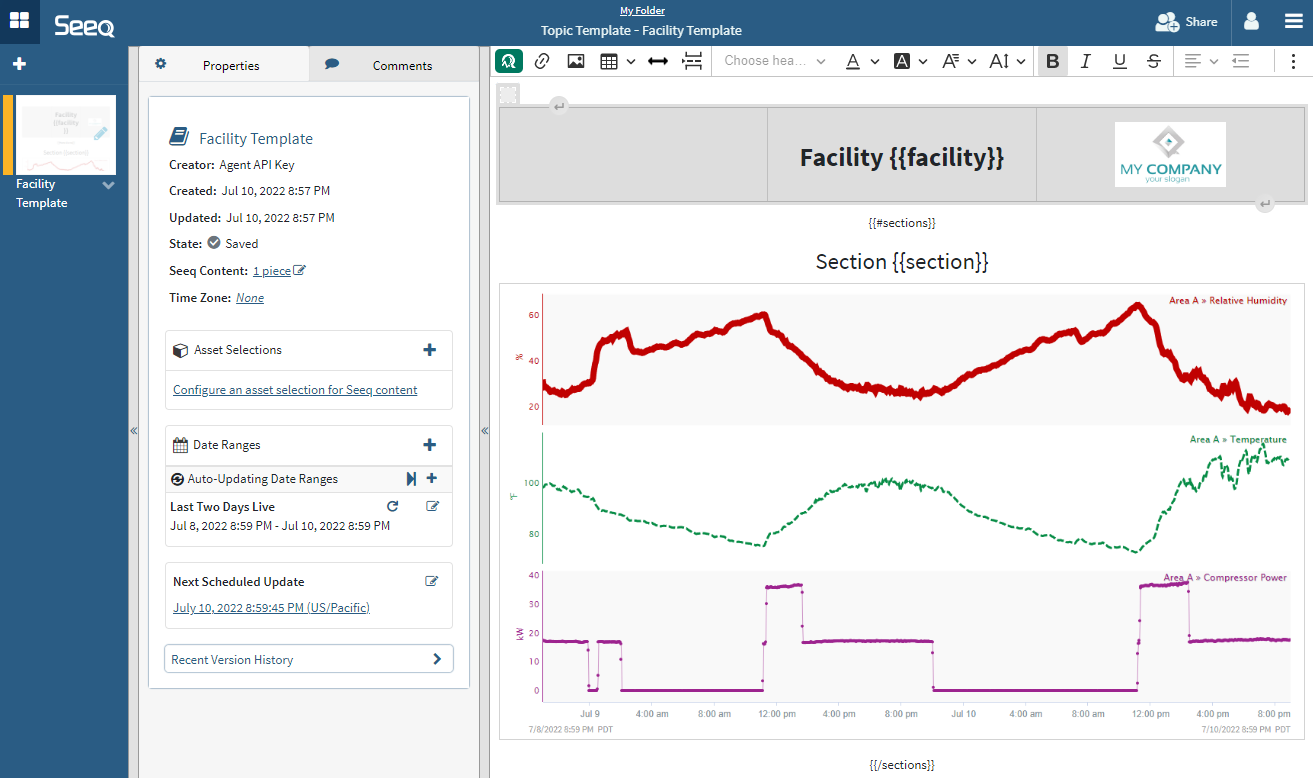

In [12]:
#
# Again, we use class inheritance here to build on what came before. Everything that was available
# in the classes above is available here as well.
#
class Facility_With_Topics(Facility_With_Displays):
    @Asset.Document()
    def My_Facility(self, metadata, topic):
        # Similar to our code above that defines an Analysis Worksheet, here we make a copy of
        # Topic Document template and give it the name of the Facility.
        document = topic.documents['Facility Template'].copy(self.fqn)

        document.name = self['Name']

        document.parameters = {
            # Grab the last character, since "Facility" is already in the template
            "facility": self['Name'][-1],

            "sections": [
                {
                    # Grab the last character, since "Section" is already in the template
                    "section": section['Name'][-1],

                    "BFA05D82-D900-44B0-95C8-4AE8B26F01BE [Embedded Content] Users >> mark-derbecker@seeq-com >> Report and Dashboard Templates >> Analysis Template >> Trend":
                        section.Ambient_Conditions()
                }
                # This is the typical way that you will iterate over all the child assets that are
                # defined by a Component function. This "list comprehension" creates a dictionary
                # (as defined directly above) for each asset in the "for" loop below.
                for section in self.Sections().assets()
            ]
        }

    @Asset.Component()
    def Sections(self, metadata):
        # Again we must override the base class to use the new Component classes.
        return self.build_components(Section_With_Displays, metadata, 'Section')


class Region_With_Topics(Region_With_Displays):
    @Asset.Component()
    def Facilities(self, metadata):
        return self.build_components(Facility_With_Topics, metadata, 'Facility')

Again we can build the assets and push into Seeq. You will now see an Organizer Topic in the `SPy Documentation Examples` folder called `Report and Dashboard Templates`.

In [13]:
build_df = spy.assets.build(Region_With_Topics, metadata_df, workbooks=workbooks, errors='raise')
pushed_df = spy.push(metadata=build_df, workbook='SPy Documentation Examples >> Report and Dashboard Templates')

# Show the inner Push Workbooks status object's display instead of the metadata push status,
# since it has links to the Topic.
pushed_df.spy.status.inner['Push Workbooks'].display()

,ID,Name,Type,Workbook Type,Count,Time,Errors,Result,Pushed Workbook ID,URL
0,0EF5BE2E-E000-7550-9998-A9C5FFE8A636,Report and Dashboard Templates,Workbook,Analysis,28,00:00:01.99,0,Success,0EF5BE2E-E000-7550-9998-A9C5FFE8A636,link
1,14079DF9-319F-4181-AEC1-9A4D48EF310B agent_api_key Report and Dashboard Templates Example 1,Report and Dashboard Templates,Workbook,Topic,6,00:00:01.25,0,Success,0EF5BE2F-0CC6-FBC0-BFF8-F40C11C6275B,link
